Esse relatório tem por objetivo expor o estudo feito por mim a partir dos dados de dor crônica, e por consequência não possui o código necessário para a reprodução do mesmo. O repositório com o código completo se encontra em (https://github.com/VictorHenrique317/ml-projeto-final) 

Os diferentes conjuntos de recursos são definidos da seguinte forma:

1. "X_questions" são as perguntas feitas ao paciente durante a consulta, contendo informações relevantes para a análise.
2. "X_drugs" consiste nos medicamentos que o paciente está tomando.
3. "X" representa a combinação dos conjuntos de recursos "X_questions" e "X_drugs", criando um conjunto mais abrangente.
4. "X_random" é um conjunto de recursos aleatórios, que contêm variáveis sem uma relação direta com as perguntas ou medicamentos.

Para melhorar a eficiência do modelo, algumas colunas não relevantes, como a data de nascimento, foram removidas, bem como as colunas que possuem um valor constante em todos os exemplos, já que essas não fornecem informações úteis para a análise. Essa seleção cuidadosa de recursos relevantes ajudará a concentrar a atenção do modelo nas informações mais significativas.

In [532]:
data = pd.read_csv('data.csv')

X_questions = data.iloc[:, 2:182] # Id e data de nascimento são irrelevantes
X_questions = X_questions.drop('date_visit', axis=1) # Data de visita não é relevante
X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

X_drugs = data.iloc[:, 185:]
X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1) # Essas colunas são constantes

X_random = np.random.rand(X_questions.shape[0], 1) # Para comparar a perfomance do modelo
X_random = pd.DataFrame(X_random)
X = np.concatenate((X_questions, X_drugs), axis=1) # A junção das duas tabelas
X = pd.DataFrame(X)

Com base nos dados fornecidos, podemos extrair três diferentes variáveis que indicam se o paciente teve melhora ou não. Essas variáveis são: "y_vas30", "y_vas50" e "y_gic".

1. "y_vas30": Essa variável indica se o paciente apresentou uma melhora de pelo menos 30% na escala de dor VAS (Visual Analog Scale - Escala Analógica Visual). Se o paciente teve uma redução de pelo menos 30% na intensidade da dor, a variável "y_vas30" é marcada como positiva, indicando melhora. Caso contrário, é marcada como negativa.

2. "y_vas50": Essa variável indica se o paciente teve uma melhora de pelo menos 50% na escala VAS. Se o paciente teve uma redução de pelo menos 50% na intensidade da dor, a variável "y_vas50" é marcada como positiva, indicando melhora. Caso contrário, é marcada como negativa.

3. "y_gic": Essa variável representa a avaliação de melhora feita pelo médico utilizando o Global Impression of Change (GIC). O médico avalia se houve uma melhora geral no estado de saúde do paciente. Se o médico considerar que houve melhora, a variável "y_gic" é marcada como positiva. Caso contrário, é marcada como negativa.

In [533]:
Y = data.iloc[:, 182:185]

y_vas30 = pd.DataFrame(Y.iloc[:, 0:1].values.ravel())
y_vas50 = pd.DataFrame(Y.iloc[:, 1:2].values.ravel())
y_gic = pd.DataFrame(Y.iloc[:, 2:3].values.ravel())

Neste ponto, nos deparamos com três alvos diferentes e precisamos decidir qual deles faz mais sentido utilizar. Considerei que não seria adequado escolher apenas um deles e ignorar os demais. Portanto, decidi criar uma nova variável que leve em consideração as três diferentes avaliações de melhora, duas feitas pelo paciente e uma feita pelo médico.

Primeiramente, criei a variável "y_perceived", que representa a melhora percebida pelo paciente. Essa variável é definida como a união das variáveis "y_vas30" e "y_vas50", pois desejo capturar qualquer tipo de melhora percebida pelo paciente, seja ela pequena (30%) ou significativa (50%).

In [534]:
y_perceived = np.logical_or(y_vas30, y_vas50)
y_perceived = y_perceived.astype(int)
y_perceived = pd.DataFrame(y_perceived)

O alvo "y" é definido como a interseção entre a melhora percebida e o GIC (Global Impression of Change - Impressão Global de Mudança). Essa definição é baseada na necessidade de o paciente perceber alguma melhora (indicado por "y_perceived") e o médico concordar com essa percepção (indicado por "y_gic"). Após uma análise experimental, verifiquei que essa é a definição de alvo que melhor se ajusta aos dados, em comparação com as outras cinco definições mencionadas anteriormente.

Dessa forma, além de fazer sentido intuitivamente, a expressividade dessa definição também foi verificada experimentalmente, demonstrando sua adequação para o propósito do estudo.

In [ ]:
y = np.logical_and(y_perceived, y_gic)
y = y.astype(int)
y = pd.DataFrame(y)

Ao adotar a definição de alvo "y" como a interseção entre a melhora percebida e o GIC, a distribuição dos dados resultantes fica desbalanceada. Apenas 15% dos exemplos são classificados como pacientes que apresentaram melhora, de acordo com o nosso alvo "y".

Essa baixa porcentagem de casos positivos em "y" faz sentido, levando em consideração a reunião em que foi discutido que a maioria dos pacientes que sofrem de dor crônica não apresentam melhora significativa. Portanto, a distribuição desigual é uma representação adequada da realidade clínica em relação à melhora dos pacientes.

In [535]:
print(f"A porcentagem de casos positivos em y_gic é {(np.sum(y_gic.values)/y_gic.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas30 é {(np.sum(y_vas30.values)/y_vas30.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas50 é {(np.sum(y_vas50.values)/y_vas50.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_perceived é {(np.sum(y_perceived.values)/y_perceived.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y é {(np.sum(y.values)/y.shape[0])*100:.2f}%")

A porcentagem de casos positivos em y_gic é 28.96%
A porcentagem de casos positivos em y_vas30 é 43.84%
A porcentagem de casos positivos em y_vas50 é 35.84%
A porcentagem de casos positivos em y_perceived é 43.84%
A porcentagem de casos positivos em y é 15.04%


O objetivo aqui é alcançar uma distribuição equilibrada entre os exemplos positivos e negativos. Isso garantirá que o modelo tenha a mesma capacidade de classificar ambos os casos, sem favorecer uma categoria em relação à outra. No entanto, a única maneira que tenho disponível para alcançar esse equilíbrio é remover os casos negativos em excesso presentes nos dados originais.

Essa situação apresenta um desafio para o modelo, uma vez que é necessário reduzir o tamanho do conjunto de treinamento, que já é limitado, contendo apenas 625 exemplos, para 201 exemplos. Sendo assim, tornar o modelo igualmente capaz de classificar ambas as categorias tem uma consequência negativa evidente: uma redução na qualidade devido à quantidade de dados reduzida. Mais adiante, mostrarei como diferentes distribuições de exemplos positivos (pacientes que apresentaram melhora) e negativos (pacientes que não apresentaram melhora) afetam o classificador.

Apesar de todos os fatos mencionados, acredito que, por se tratar de um modelo com grande responsabilidade na área da saúde, é essencial que ele seja justo e equilibrado na classificação dos casos, minimizando assim os falsos negativos e falsos positivos que, nesse contexto, representam cenários prejudiciais para as pessoas. Além disso, levar em consideração todos os 625 dados originais torna o modelo ineficaz, como demonstrarei mais adiante. 

A distribuição equilibrada dos targets também ajuda a evitar problemas como o viés do modelo em direção à categoria majoritária, que pode ocorrer quando há um desequilíbrio significativo na distribuição dos dados. É importante ressaltar que a obtenção de uma distribuição equilibrada não apenas melhora a qualidade do modelo, mas também aumenta sua confiabilidade e aplicabilidade em diferentes cenários e contextos.

In [536]:
print(y.shape)
zero_rows = y.index[(y == 0).all(axis=1)]
delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1.25), replace=False)

X = X.drop(delete_rows)
X_drugs = X_drugs.drop(delete_rows)
X_questions = X_questions.drop(delete_rows)
X_random = np.delete(X_random, delete_rows, axis=0)

y_gic = y_gic.drop(delete_rows)
y_vas30 = y_vas30.drop(delete_rows)
y_vas50 = y_vas50.drop(delete_rows)
y_perceived = y_perceived.drop(delete_rows)
y = y.drop(delete_rows)

print(X.shape)
print(X_questions.shape)
print(X_drugs.shape)
print(y.shape)

(625, 1)
(201, 312)
(201, 175)
(201, 137)
(201, 1)


É possível observar que, com a extração do excesso de casos negativos, a distribuição dos targets, incluindo "y" e os outros targets alternativos, tornou-se equilibrada.

In [537]:
print(f"A porcentagem de casos positivos em y_gic é {(np.sum(y_gic.values)/y_gic.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas30 é {(np.sum(y_vas30.values)/y_vas30.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas50 é {(np.sum(y_vas50.values)/y_vas50.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_perceived é {(np.sum(y_perceived.values)/y_perceived.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y é {(np.sum(y.values)/y.shape[0])*100:.2f}%")

A porcentagem de casos positivos em y_gic é 54.73%
A porcentagem de casos positivos em y_vas30 é 60.70%
A porcentagem de casos positivos em y_vas50 é 51.24%
A porcentagem de casos positivos em y_perceived é 60.70%
A porcentagem de casos positivos em y é 46.77%


Pré-processamento dos dados.

In [538]:
# Codificando as variáveis categóricas
le = LabelEncoder()
for col in X_questions.columns:
    if X_questions[col].dtype == 'bool':
        X_questions[col] = le.fit_transform(X_questions[col])

for col in X_drugs.columns:
    if X_drugs[col].dtype == 'bool':
        X_drugs[col] = le.fit_transform(X_drugs[col])

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = le.fit_transform(X[col])

# Imputando os valores que faltam
imp = SimpleImputer(strategy='mean')
imp.fit(X_questions)
X_questions = imp.transform(X_questions)

imp = SimpleImputer(strategy='mean')
imp.fit(X_drugs)
X_drugs = imp.transform(X_drugs)

imp = SimpleImputer(strategy='mean')
imp.fit(X)
X = imp.transform(X)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_drugs = scaler.fit_transform(X_drugs)
X_questions = scaler.fit_transform(X_questions)
X_random = scaler.fit_transform(X_random)

X = pd.DataFrame(X)
X_drugs = pd.DataFrame(X_drugs)
X_questions = pd.DataFrame(X_questions)
X_random = pd.DataFrame(X_random)

y_gic = pd.DataFrame(y_gic)
y_vas30 = pd.DataFrame(y_vas30)
y_vas50 = pd.DataFrame(y_vas50)
y_perceived = pd.DataFrame(y_perceived)
y = pd.DataFrame(y)

Para treinar os diferentes algoritmos selecionados, defini funções específicas. A fim de obter uma melhor estimativa do erro esperado, os erros de teste são calculados usando a técnica de validação cruzada com 5 'folds'. Durante esse processo, as acurácias dos modelos também são registradas para cada iteração da validação cruzada.

Na seleção dos algoritmos, optei por dois que demonstraram boa eficiência mesmo com conjuntos de dados menores: XGBoosting e RandomForest. Além disso, por curiosidade e para fins comparativos, também treinei MLPs, que naturalmente requerem uma quantidade maior de dados.

In [539]:
def trainClassifier(X, y, clf, print_accuracy=False):
    kf = KFold(n_splits=5)
    empirical_losses = []
    test_losses = []
    empirical_accuracies = []
    test_accuracies = []

    for train_indices, test_indices in kf.split(X):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        clf.fit(X_train, y_train) # classificador generico

        empirical_loss = log_loss(y_train, clf.predict(X_train))
        test_loss = log_loss(y_test, clf.predict(X_test))

        empirical_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)

        empirical_losses.append(empirical_loss)
        test_losses.append(test_loss)

        empirical_accuracies.append(empirical_accuracy)
        test_accuracies.append(test_accuracy)

    empirical_loss = np.mean(empirical_losses)
    test_loss = np.mean(test_losses)

    empirical_accuracy = np.mean(empirical_accuracies) * 100
    test_accuracy = np.mean(test_accuracies) * 100

    if print_accuracy:
        print(f"empirical_accuracy: {empirical_accuracy: .2f}% | test_accuracy: {test_accuracy: .2f}% ")

    return (empirical_loss, test_loss, test_accuracy)

def trainXGBBoostingClassifier(X, y, max_depth=0, gamma=0.0, print_accuracy=False, print_importance=False):
    clf = xgb.XGBClassifier(max_depth=max_depth,  gamma=gamma, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
    
    if print_importance:
        clf.fit(X, y)
        feat_imp = pd.Series(clf.get_booster().get_fscore())
        feat_imp.index = pd.Index(feat_imp.index)
        feat_imp.sort_values(ascending=False, inplace=True)
        feat_imp.plot(kind='bar', title='Importância da feature', width=0.8, figsize=(20,10))
        plt.ylabel('Avaliação de importância da feature')
        
    return trainClassifier(X, y, clf, print_accuracy)

def trainMLPClassifier(X, y, hidden_layer_size=0, print_accuracy=False):
    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), solver='sgd', learning_rate_init=0.01,
                        max_iter=2000, verbose=False)
    return trainClassifier(X, y, clf, print_accuracy)

def trainRandomForestClassifier(X, y, max_depth=0, print_accuracy=False):
    clf =clf = RandomForestClassifier(n_estimators=1000, max_depth=max_depth)
    return trainClassifier(X, y, clf, print_accuracy)

Agora é a fase de seleção de modelos, para cada combinação (algoritmo, conjunto de features) plotei o gráfico de erro x capacidade para identificar o nível ideal de complexidade e o conjunto de features que é mais adequado para a classificação.

- A medida de complexidade para as MLP's de 3 camadas é o número de neurônios na camada oculta.
- A medida de complexidade para as Random Forests é a profundidade máxima das árvores (classificadores individuais).
- A medida de complexidade para o XGBoost é a profundidade máxima das árvores (classificadores individuais).

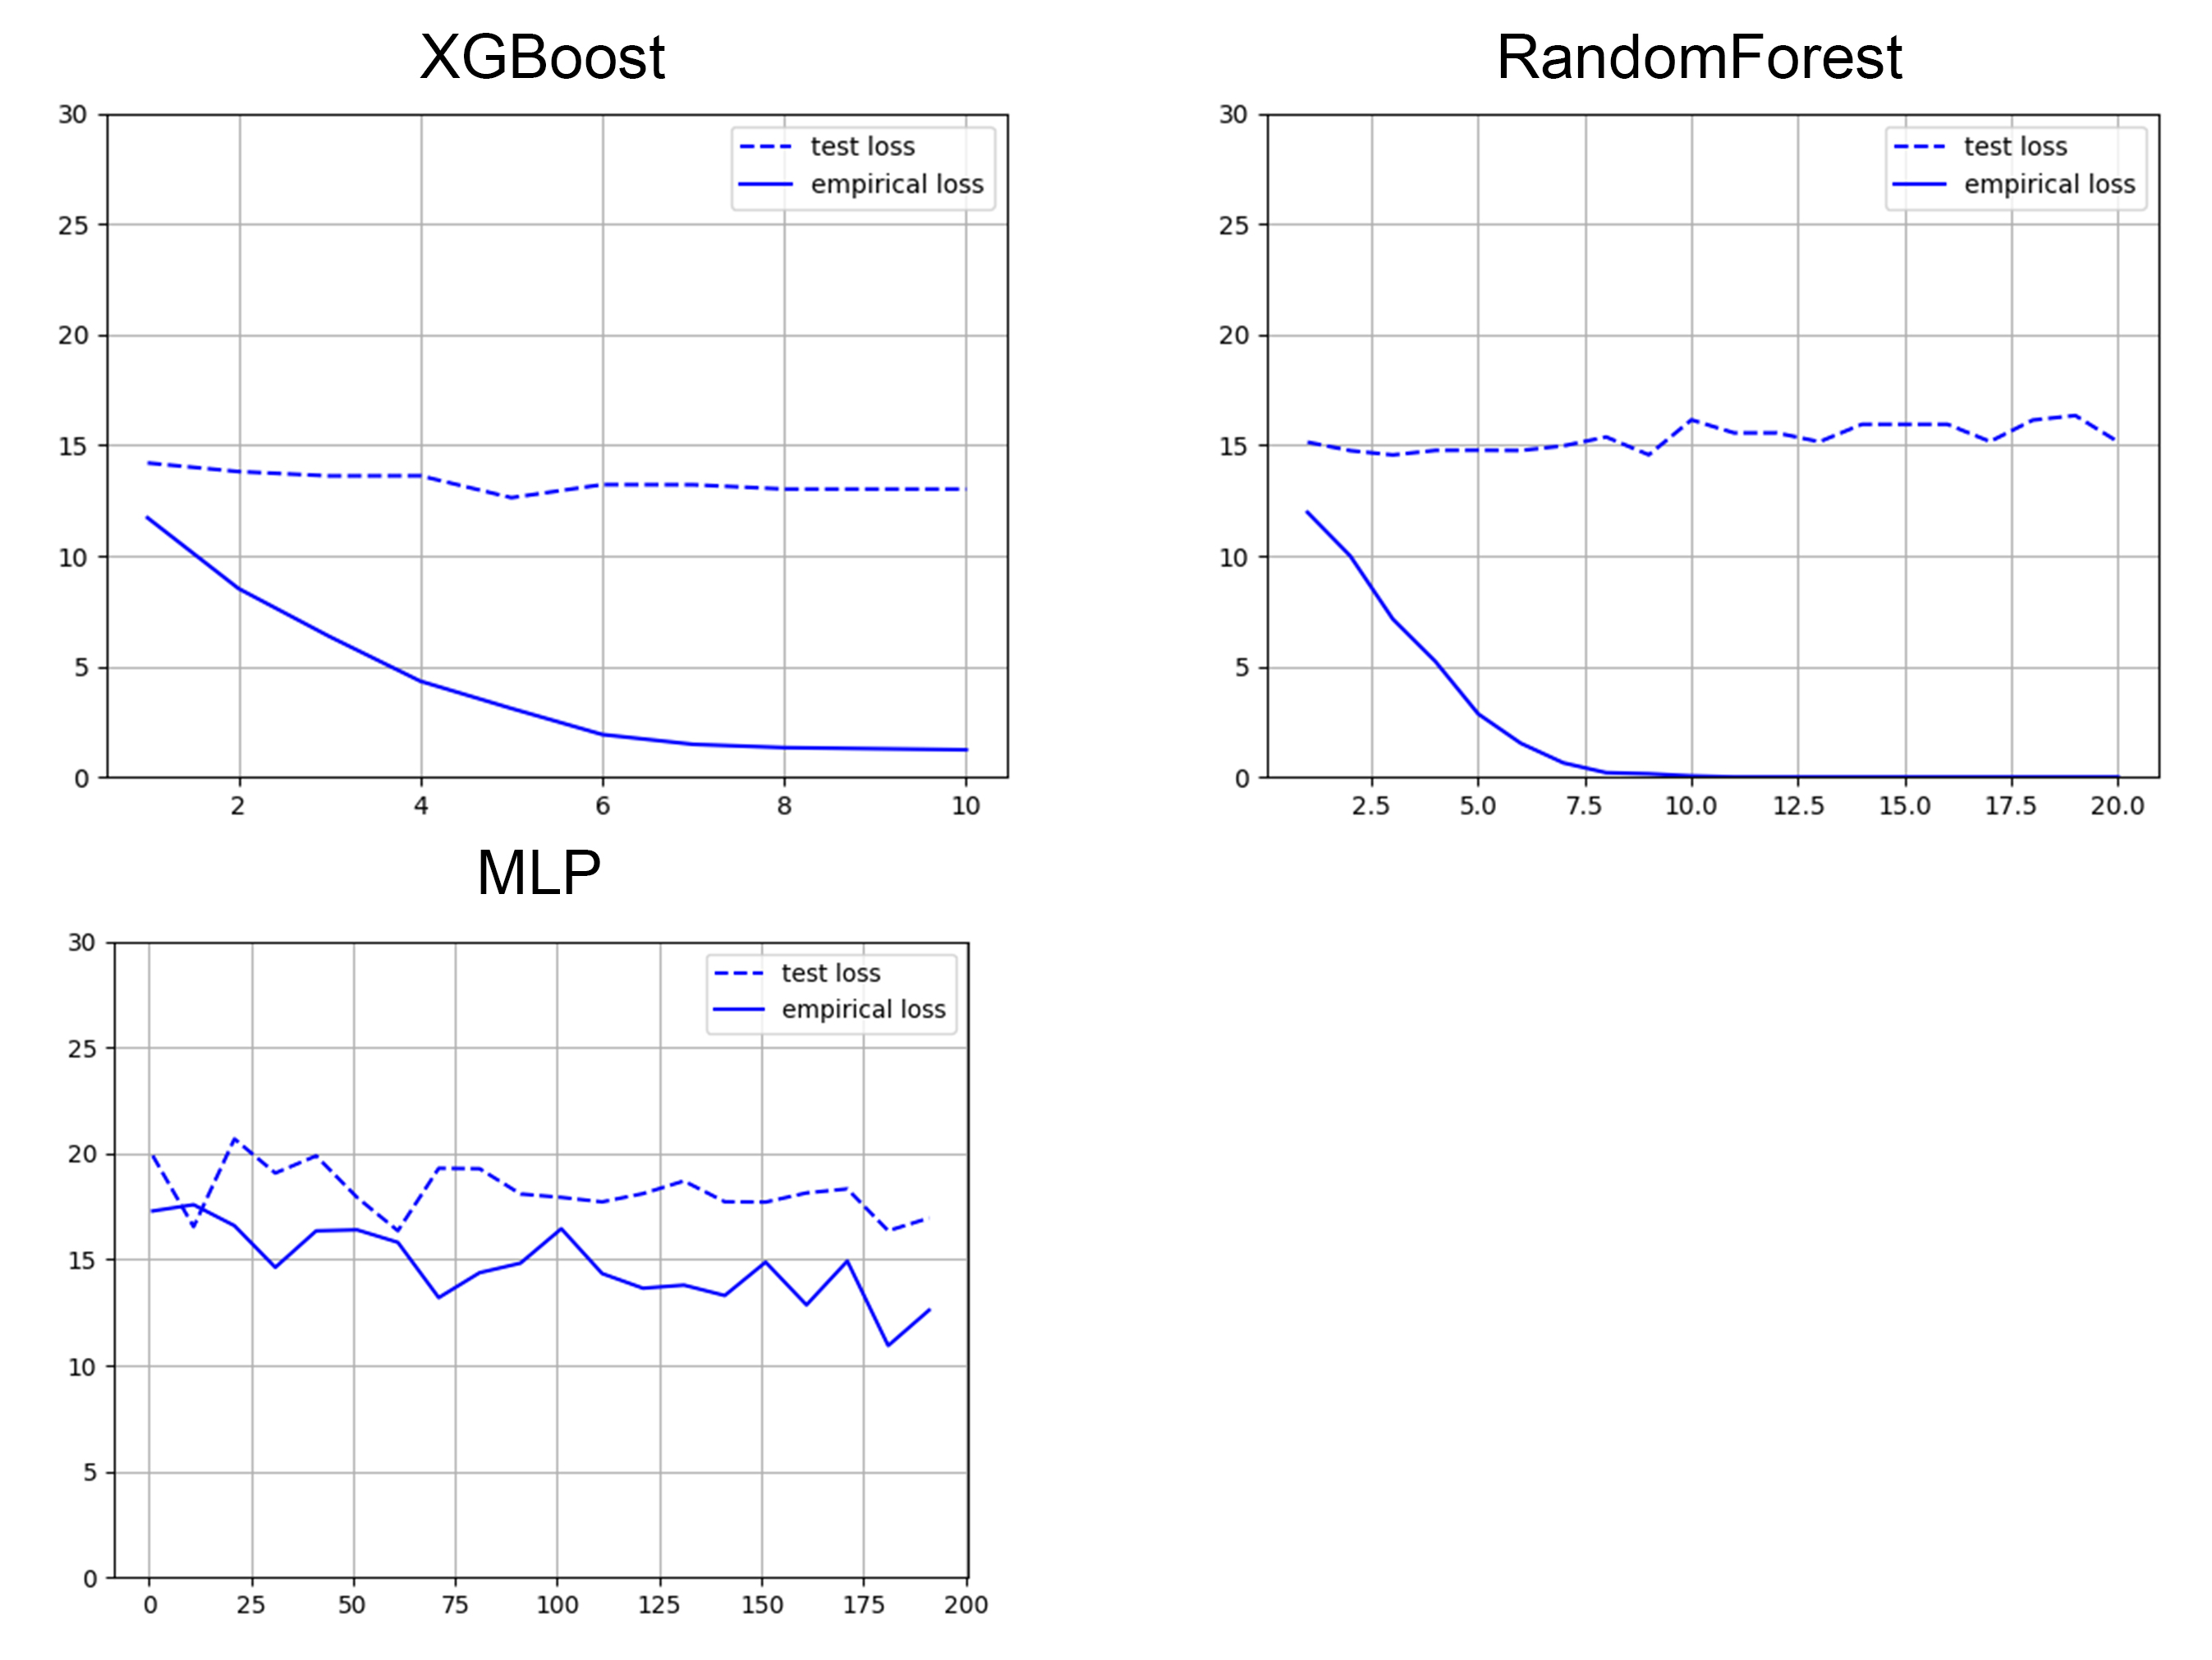

In [544]:
Image(filename='plots/manual/models_capacity_x.jpg')

Selecionei o XGBoost pois ele tem resultados ligeramente melhores (menor erro de teste e maior acuracia) que os da random forest, e alem disso ele tem mais hiperparâmetros para ajustar a qualidade do modelo. Como esperado o desempenho da MLP é baixo e não consistente ao longo dos diferentes níveis de complexidade.

O ajuste de hiperparâmetros nesse contexto não é muito relevante, já que a qualidade geral dos modelos é bem baixa devido ao pequeno número de dados.

Comparei os diferentes modelos primeiro considerando apenas o conjunto de features X, depois de selecionado o modelo podemos ver como os diferentes conjuntos de features afetam a capacidade preditiva.

Agora que selecionamos o melhor modelo podemos analisar como os diferentes conjuntos de features afetam a capacidade preditiva. Para fins comparação gerei X_random, um conjunto de features aleatórias que nos permite ver o quão menor o erro de teste de cada conjunto está em relação ao erro de teste gerado a partir de valores aleatórios.

X_questions e X_drugs geram um desempenho semelhante, porém x_questions gera resultados levemente melhores. Quando usamos todas a as features disponíveis (X) temos o melhor modelo por uma faixa bem pequena.

Com esses resultados não conseguimos afirmar com certeza se os remédios que o paciente toma podem ser usados para predizer se ele vai ter uma melhora em sua dor crônica ou não. Isso porque o melhor desempenho do modelo que usa o conjunto X pode ser explicado tanto pelo presença das features de remédios quanto pelo aumento da dimensionalidade dos dados. Lembrando que quanto maior a dimensionalidade dos dados maior a chance do modelo ser linearmente separável, e por consequência ter um melhor desempenho.

Porém, não podemos esquecer do fato que o modelo que usa X_drugs é tão bom quanto o que usa X_questions. Isso pode ser um indício que os remédios tem sim alguma capacidade preditiva, já que já foi comprovado que X_questions pode ser usado para fazer essa predição (como discutido em nossa reunião).

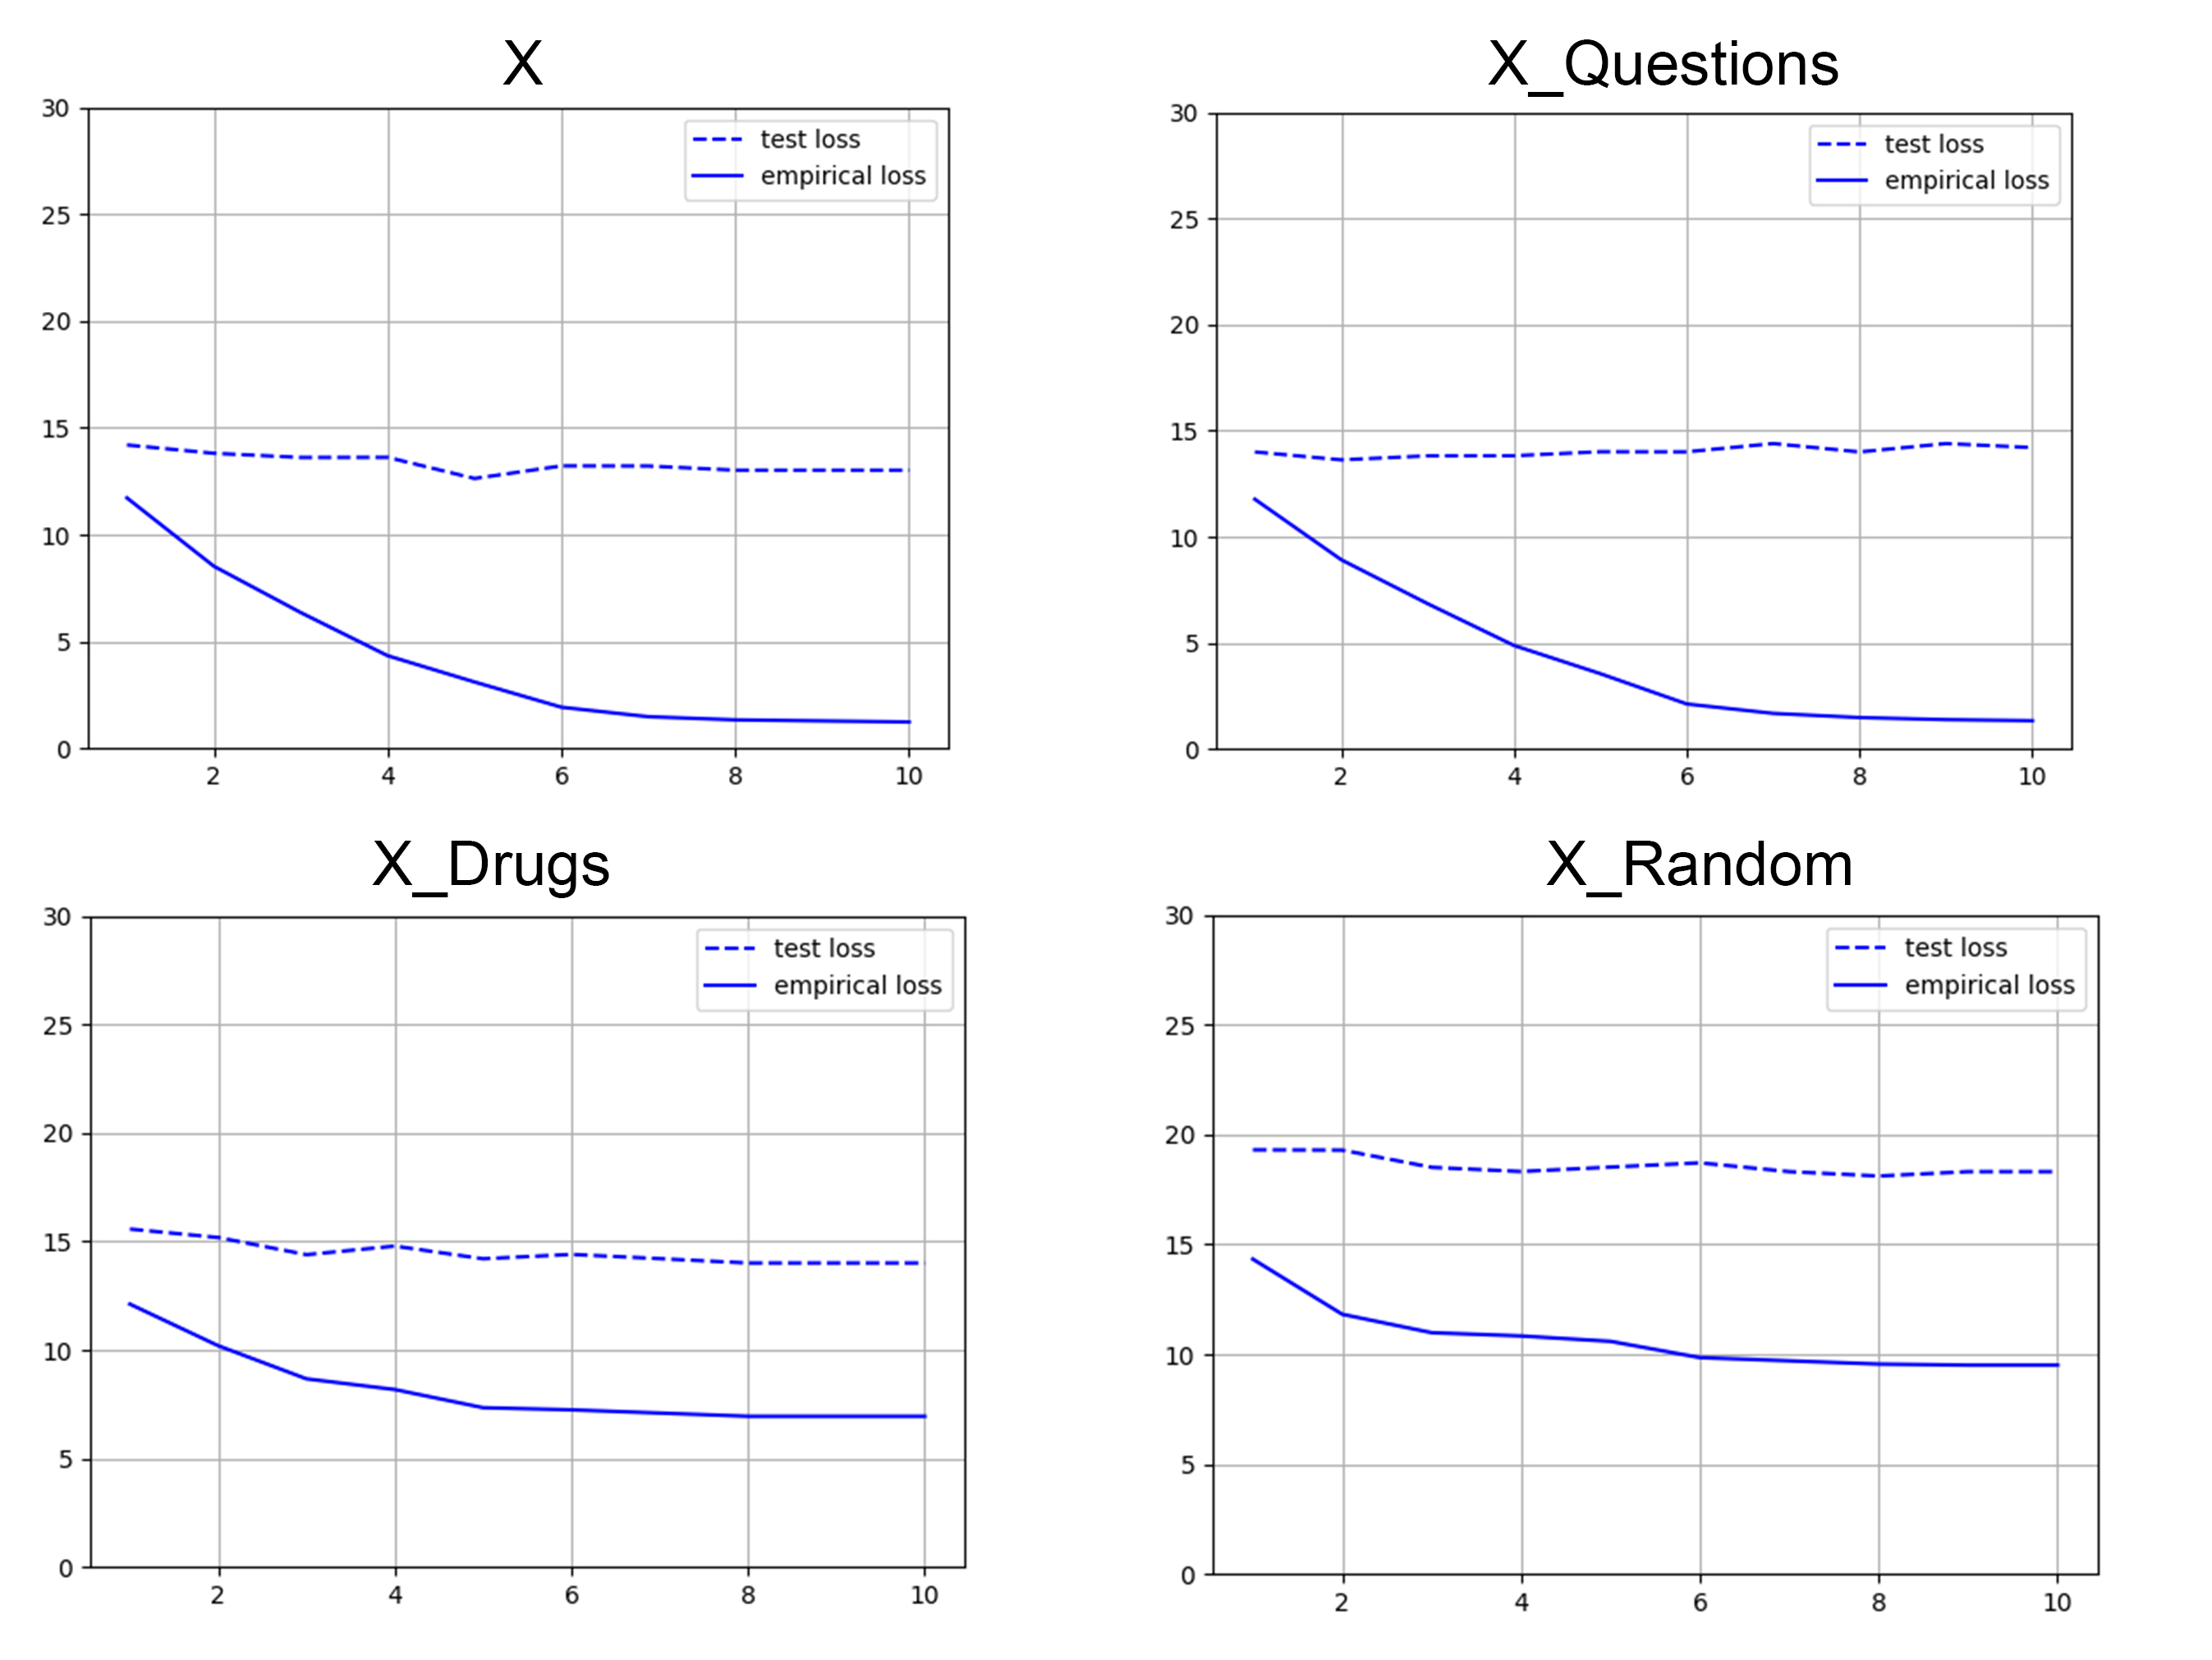

In [545]:
Image(filename='plots/manual/xgboost_features.jpg')

Para fazer uma última análise do modelo obtido usaremos o princípio da navalha de Ockham para escolher o conjunto de features X_questions, já que ele é menos complexo que X e gera um modelo com aproximadamente a mesma qualidade.

Podemos observar que pela confusion matrix dos dados originais (com uma distribuição assimétrica) que o modelo é completamente desbalanceado, só sabendo identificar verdadeiros negativos e tendo uma péssima acurácia para verdadeiros positivos. Enquanto o outro, apesar de ter piores resultados, é mais balanceado em suas classificações.

In [546]:
def meanConfusionMatrix(X, y, name, test_accuracy):
    k = 20
    mean_confusion_matrix = np.zeros((2,2))
    kfold = KFold(n_splits=k, shuffle=True)

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mean_confusion_matrix += confusion_matrix(y_test, y_pred)

    mean_confusion_matrix /= k
    sns.set(font_scale=1.4)
    sns.heatmap(mean_confusion_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='.2g')

    plt.title(name)
    plt.xlabel(f"Categoria predita ({test_accuracy:.2f}% de acurácia no teste)")
    plt.ylabel('Categoria real')
    plt.show()

# test_accuracy = trainXGBBoostingClassifier(X_questions, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=False)
# test_accuracy = test_accuracy[2]
# meanConfusionMatrix(X_questions, y, 'Usando a distribuição balanceada', test_accuracy)

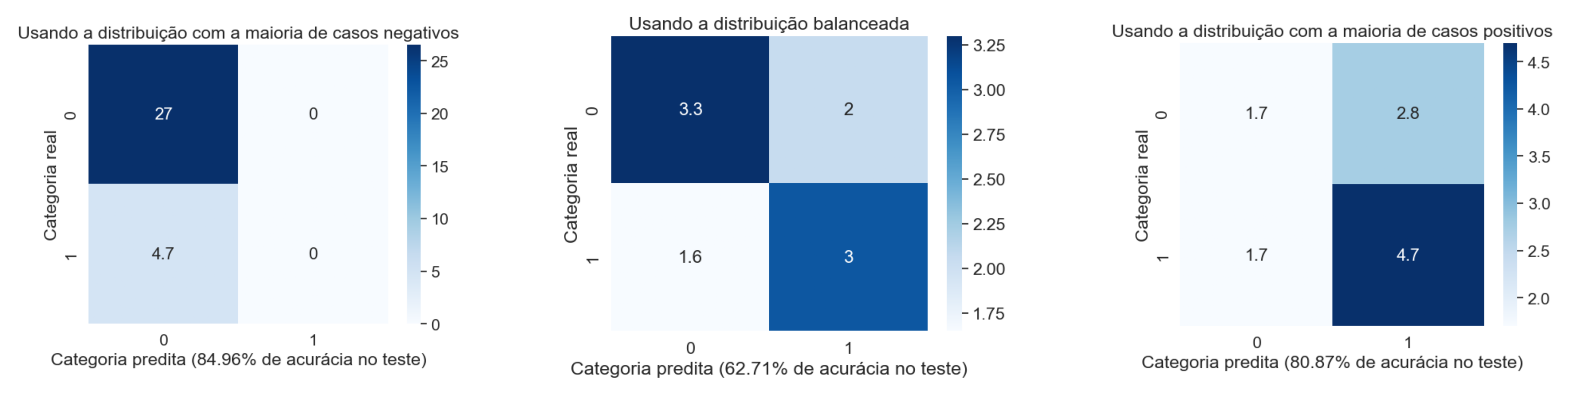

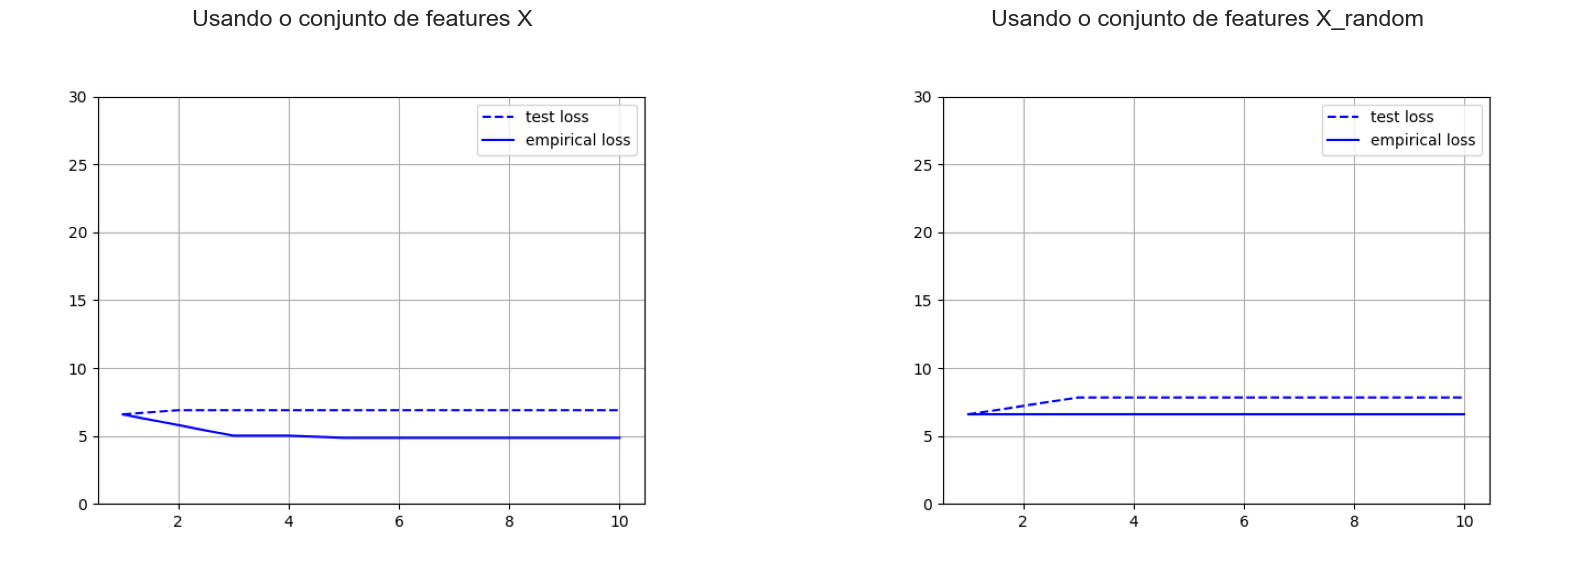

In [547]:
# Image(filename='plots/manual/confusion_matrix_negative_distribution.png')
image1 = imread('plots/manual/confusion_matrix_negative_distribution.png')
image2 = imread('plots/manual/confusion_matrix_balanced_distribution.png')
image3 = imread('plots/manual/confusion_matrix_positive_distribution.png')
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

image1 = imread('plots/xgboost/x.png')
image2 = imread('plots/xgboost/x_random.png')
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image1)
axs[0].set_title('Usando o conjunto de features X')
axs[1].imshow(image2)
axs[1].set_title('Usando o conjunto de features X_random')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Vejamos quais são as features mais importantes para o classificador XGBoost.

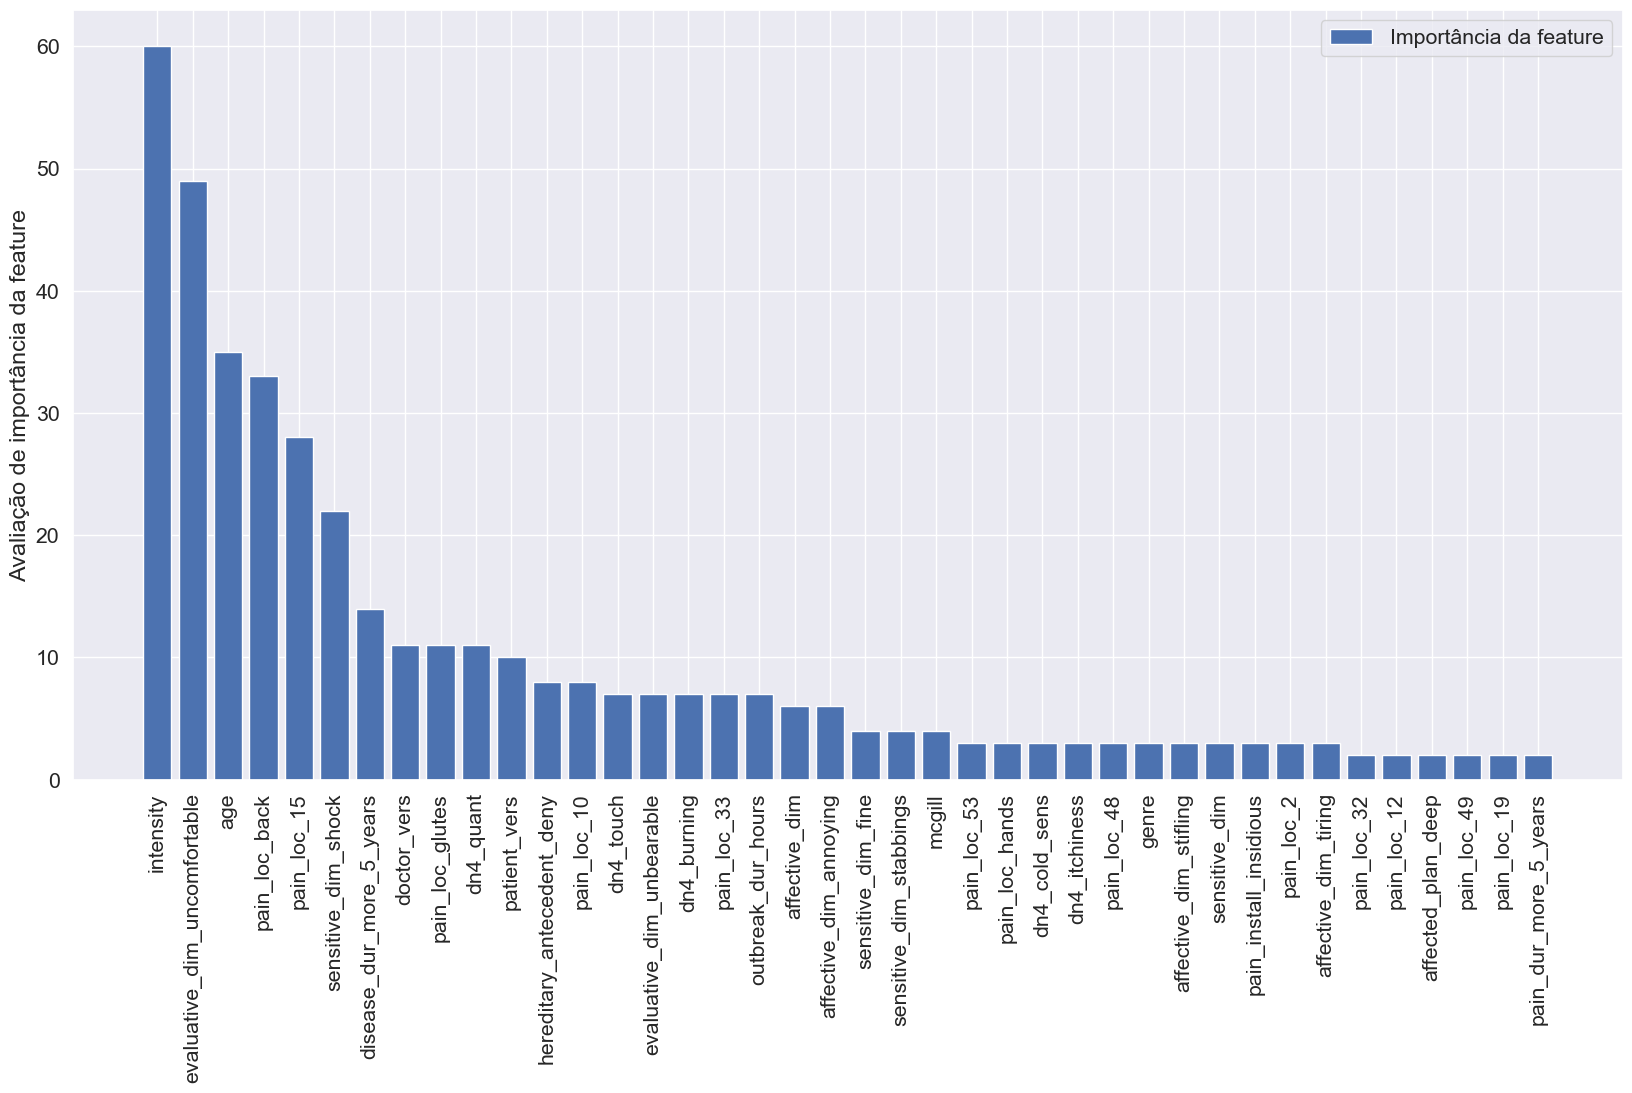

In [548]:
df = pd.read_csv("data.csv")
questions = df.iloc[:, 2:182]
questions = questions.drop('date_visit', axis=1)
questions = questions.drop(questions.columns[[46, 133, 158, 161]], axis=1)

drugs = data.iloc[:, 185:]
drugs = drugs.drop(drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1)

features = pd.concat([questions, drugs], axis=1)
features = list(features.columns)

clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
clf.fit(X_questions, y)

feat_imp = pd.Series(clf.get_booster().get_fscore())
feat_imp.index = pd.Index(feat_imp.index)
feat_imp.sort_values(ascending=False, inplace=True)

x_plot = [ int(f.replace("f", "")) for f in feat_imp.index]
y_plot = [ feat_imp[f] for f in feat_imp.index]
x_plot = [features[feature_index] for feature_index in x_plot]

max_features = 40
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x_plot[:max_features], y_plot[:max_features], label="Importância da feature")
ax.set_ylabel("Avaliação de importância da feature")
plt.xticks(rotation=90)
ax.legend()
plt.show()

Conclusão: Mais dados são necessários para afirmar responsavelmente se os remédios predizem (ou não) a melhora dos pacientes, principalmente dados de casos positivos.